# Audio Analysis Example
This notebook will go through performing machine learning and analysis on audio data as an example primer on the actual bird calling data we will use it on. The notebook is taken from Microsoft's [Intro to Audio Classification with PyTorch](https://docs.microsoft.com/en-us/learn/modules/intro-audio-classification-pytorch/) module. The audio files on there are fairly simple, but the concept remains.

## Import Packages
Import all the packages we will use. The `torchaudio` package is the main one.

In [21]:
import os
import torchaudio
import IPython.display as ipd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchinfo import summary

from pathlib import Path

## Get the SpeechCommands dataset
We will be using the speech commands dataset, an audio dataset where each audio file is an extremely short one-word audio of a simple command.

In [2]:
# Use the ./Data/ folder to store it....
DATA_DIR = './Data/'
# Download and save the dataset
trainset_speechcommands = torchaudio.datasets.SPEECHCOMMANDS(DATA_DIR, download=True)

In [3]:
# Count how many labels there are. There are 4 regular files in the subdirectory so subtract 4
speech_command_dir = os.path.join(DATA_DIR, 'SpeechCommands', 'speech_commands_v0.02')
labels = [name for name in os.listdir(speech_command_dir) if not os.path.isfile(os.path.join(speech_command_dir, name))]
print(f'There are {len(labels)} labels')
print(labels)

There are 36 labels
['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero', '_background_noise_']


## Visualizing a single waveform

In [4]:
filename = os.path.join(speech_command_dir, 'yes', '00f0204f_nohash_0.wav')
waveform, sample_rate = torchaudio.load(filepath=filename, num_frames=3)
print(f'waveform tensor with 3 frames:  {waveform} \n')
waveform, sample_rate = torchaudio.load(filepath=filename, num_frames=3, frame_offset =2)
print(f'waveform tensor with 2 frame_offsets: {waveform} \n')
waveform, sample_rate = torchaudio.load(filepath=filename)
print(f'waveform tensor:  {waveform}' )

waveform tensor with 3 frames:  tensor([[0.0005, 0.0007, 0.0005]]) 

waveform tensor with 2 frame_offsets: tensor([[0.0005, 0.0004, 0.0007]]) 

waveform tensor:  tensor([[0.0005, 0.0007, 0.0005,  ..., 0.0008, 0.0008, 0.0007]])


In [5]:
# Function to plot the audio
def plot_audio(filename):
    waveform, sample_rate = torchaudio.load(filename)

    print(f'Shape of waveform: {waveform.size()}')
    print(f'Sample rate of waveform: {sample_rate}')

    plt.figure()
    plt.plot(waveform.t().numpy())

    return waveform, sample_rate

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


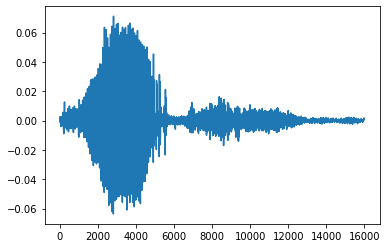

In [6]:
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


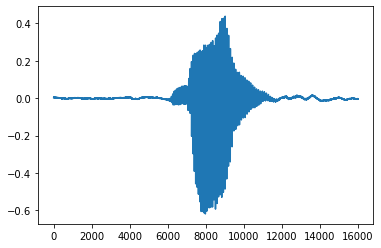

In [7]:
# Let's look at a NO
filename = os.path.join(speech_command_dir, 'no', '0b40aa8e_nohash_0.wav')
waveform, sample_rate = plot_audio(filename)
ipd.Audio(waveform.numpy(), rate=sample_rate)

## Datasets and DataLoaders
Next, we'll create the dataset and dataloaders for the yes and no audio files.

In [8]:
def load_audio_files(path, label):
    dataset = []
    walker = sorted(str(p) for p in Path(path).glob('*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split('_nohash_')
        utterance_number = int(utterance_number)

        # Load audio
        waveform, sample_rate = torchaudio.load(file_path)
        dataset.append([waveform, sample_rate, label, speaker_id, utterance_number])

    return dataset

In [9]:
# Load the yes and no dataset
trainset_speechcommands_yes = load_audio_files(os.path.join(speech_command_dir, 'yes'), 'yes')
trainset_speechcommands_no = load_audio_files(os.path.join(speech_command_dir, 'no'), 'no')

print(f'Yes: {len(trainset_speechcommands_yes)}')
print(f'No: {len(trainset_speechcommands_no)}')

Yes: 4044
No: 3941


In [10]:
# Dataloaders
trainloader_yes = DataLoader(trainset_speechcommands_yes, batch_size=1, shuffle=True, num_workers=0)
trainloader_no = DataLoader(trainset_speechcommands_no, batch_size=1, shuffle=True, num_workers=0)

In [11]:
yes_waveform = trainset_speechcommands_yes[0][0]
yes_sample_rate = trainset_speechcommands_yes[0][1]
print(f'Yes Waveform: {yes_waveform}')
print(f'Yes Sample Rate: {yes_sample_rate}')
print(f'Yes Label: {trainset_speechcommands_yes[0][2]}')
print(f'Yes ID: {trainset_speechcommands_yes[0][3]} \n')

no_waveform = trainset_speechcommands_no[0][0]
no_sample_rate = trainset_speechcommands_no[0][1]
print(f'No Waveform: {no_waveform}')
print(f'No Sample Rate: {no_sample_rate}')
print(f'No Label: {trainset_speechcommands_no[0][2]}')
print(f'No ID: {trainset_speechcommands_no[0][3]}')

Yes Waveform: tensor([[-0.0028, -0.0054, -0.0034,  ..., -0.0011, -0.0013, -0.0014]])
Yes Sample Rate: 16000
Yes Label: yes
Yes ID: 004ae714 

No Waveform: tensor([[0.0072, 0.0061, 0.0055,  ..., 0.0098, 0.0085, 0.0092]])
No Sample Rate: 16000
No Label: no
No ID: 012c8314


In [12]:
def show_spectrogram(waveform_classA, waveform_classB):
    yes_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classA)
    print("\nShape of yes spectrogram: {}".format(yes_spectrogram.size()))
    
    no_spectrogram = torchaudio.transforms.Spectrogram()(waveform_classB)
    print("Shape of no spectrogram: {}".format(no_spectrogram.size()))

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Features of {}".format('no'))
    plt.imshow(yes_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    
    plt.subplot(1, 2, 2)
    plt.title("Features of {}".format('yes'))
    plt.imshow(no_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')  


Shape of yes spectrogram: torch.Size([1, 201, 81])
Shape of no spectrogram: torch.Size([1, 201, 81])


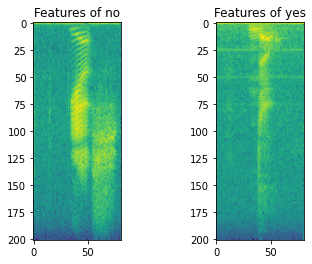

In [13]:
show_spectrogram(yes_waveform, no_waveform)

## Mel Spetrogram
Another type of spectrogram.

In [14]:
def show_melspectrogram(waveform,sample_rate):
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mel_spectrogram.size()))

    plt.figure()
    plt.imshow(mel_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

Shape of spectrogram: torch.Size([1, 128, 81])


C:\Users\mughi\miniconda3\envs\pytorch_suite\lib\site-packages\torchaudio\functional\functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


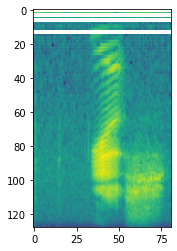

In [15]:
show_melspectrogram(yes_waveform, yes_sample_rate)

## MFCC

In [16]:
def show_mfcc(waveform,sample_rate):
    mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)
    print("Shape of spectrogram: {}".format(mfcc_spectrogram.size()))

    plt.figure()
    fig1 = plt.gcf()
    plt.imshow(mfcc_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')
    
    plt.figure()
    plt.plot(mfcc_spectrogram.log2()[0,:,:].numpy())
    plt.draw()

Shape of spectrogram: torch.Size([1, 40, 81])


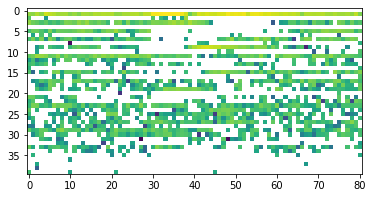

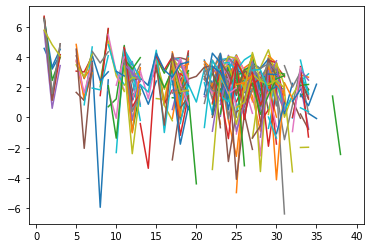

In [17]:
show_mfcc(no_waveform, no_sample_rate)

## Creating Image datasets for spectrograms and MFCCs

In [18]:
def create_spectrogram_images(trainloader, label_dir):
    #make directory
    directory = f'./Data/SpeechCommands/spectrograms/{label_dir}/'
    if(os.path.isdir(directory)):
        print("Data exists for", label_dir)
    else:
        os.makedirs(directory, mode=0o777, exist_ok=True)
        
        for i, data in enumerate(trainloader):

            waveform = data[0]
            sample_rate = data[1][0]
            label = data[2]
            ID = data[3]

            # create transformed waveforms
            spectrogram_tensor = torchaudio.transforms.Spectrogram()(waveform)     
            
            fig = plt.figure()
            plt.imsave(f'./Data///SpeechCommands/spectrograms/{label_dir}/spec_img{i}.png', spectrogram_tensor[0].log2()[0,:,:].numpy(), cmap='viridis')


In [19]:
def create_mfcc_images(trainloader, label_dir):
    #make directory
    os.makedirs(f'./Data/SpeechCommands/mfcc_spectrograms/{label_dir}/', mode=0o777, exist_ok=True)
    
    for i, data in enumerate(trainloader):

        waveform = data[0]
        sample_rate = data[1][0]
        label = data[2]
        ID = data[3]
        
        mfcc_spectrogram = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)

        plt.figure()
        fig1 = plt.gcf()
        plt.imshow(mfcc_spectrogram[0].log2()[0,:,:].numpy(), cmap='viridis')
        plt.draw()
        fig1.savefig(f'./Data/SpeechCommands/mfcc_spectrograms/{label_dir}/spec_img{i}.png', dpi=100)
 
        #spectorgram_train.append([spectrogram_tensor, label, sample_rate, ID])

In [20]:
create_spectrogram_images(trainloader_yes, 'yes')
create_spectrogram_images(trainloader_no, 'no')

Data exists for yes
Data exists for no


## Load Spectrogram Images into DataLoader

In [24]:
data_path = os.path.join(DATA_DIR, 'SpeechCommands', 'spectrograms')
yes_no_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([
        transforms.Resize((201, 81)),
        transforms.ToTensor()
    ])
)
print(yes_no_dataset)

Dataset ImageFolder
    Number of datapoints: 7985
    Root location: ./Data/SpeechCommands\spectrograms
    StandardTransform
Transform: Compose(
               Resize(size=(201, 81), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [25]:
class_map = yes_no_dataset.class_to_idx
print(f'Class category and index of files: {class_map}')

Class category and index of files: {'no': 0, 'yes': 1}


## Split Data into Training and Testing
Standard issue way of working with this data. Create separate training and testing data.

In [26]:
train_size = int(0.8 * len(yes_no_dataset))
test_size = len(yes_no_dataset) - train_size

yes_no_train_dataset, yes_no_test_dataset = torch.utils.data.random_split(yes_no_dataset, [train_size, test_size])

print('Training Size:', len(yes_no_train_dataset))
print('Testing Size:', len(yes_no_test_dataset))

Training Size: 6388
Testing Size: 1597


Next, create the training and testing data loaders.

In [36]:
train_dataloader = DataLoader(
    yes_no_train_dataset,
    batch_size=8,
    num_workers=2,
    shuffle=True
)
test_dataloader = DataLoader(
    yes_no_test_dataset,
    batch_size=8,
    num_workers=2,
    shuffle=True
)

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


## Model Definition
Next, we'll define the model we will be using.

In [37]:
class CNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(51136, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x, dim=1)

model = CNN_Net().to(device)

## Training and Testing Functions

In [38]:
loss_fn = torch.nn.CrossEntropyLoss()
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

def train(dataloader, model: nn.Module, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')

def test(dataloader, model: nn.Module):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

## Training

In [39]:
EPOCHS = 15
for t in range(EPOCHS):
    print(f'Epoch {t + 1}\n---------------------------------')
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print('Done!')

Epoch 1
---------------------------------
loss: 0.688720  [    0/ 6388]
loss: 0.412974  [  800/ 6388]
loss: 0.556489  [ 1600/ 6388]
loss: 0.019980  [ 2400/ 6388]
loss: 0.182999  [ 3200/ 6388]
loss: 0.158390  [ 4000/ 6388]
loss: 0.161972  [ 4800/ 6388]
loss: 0.377503  [ 5600/ 6388]

Test Error:
acc: 90.9%, avg loss: 0.026409

Epoch 2
---------------------------------
loss: 0.207314  [    0/ 6388]
loss: 0.079693  [  800/ 6388]
loss: 0.318904  [ 1600/ 6388]
loss: 0.130380  [ 2400/ 6388]
loss: 0.406082  [ 3200/ 6388]
loss: 0.149328  [ 4000/ 6388]
loss: 0.258704  [ 4800/ 6388]
loss: 0.099115  [ 5600/ 6388]

Test Error:
acc: 92.9%, avg loss: 0.021842

Epoch 3
---------------------------------
loss: 0.318926  [    0/ 6388]
loss: 0.042366  [  800/ 6388]
loss: 0.457963  [ 1600/ 6388]
loss: 0.092590  [ 2400/ 6388]
loss: 0.037401  [ 3200/ 6388]
loss: 0.270835  [ 4000/ 6388]
loss: 0.058058  [ 4800/ 6388]
loss: 0.037895  [ 5600/ 6388]

Test Error:
acc: 94.2%, avg loss: 0.018739

Epoch 4
-----------